# Lab 3.3: Using prior information for image registration
In this lab, you will use SimpleITK and work on improving the performance of linear registration by including prior information.

In order for some parts of this lab to work, you should first enable the widgetsnbextension of the Jupyter notebook by running from your terminal:<br>
jupyter nbextension enable --py --sys-prefix widgetsnbextension

## Using masks with regions of interest
As always, you should start by importing the useful modules below. Some of them are in the folder 'L3.3_utilities': they include useful classes and functions which are freely available in the GitHub repository of the [Insight Software Consortium](https://github.com/InsightSoftwareConsortium).

In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# from Insight Software Consortium Github
%run ./L3.3_utilities/popi_utilities_setup.py

You can now read two skull radiographic images ('001.png' and '002.png'), as well as 'mask001.png' which masks the desired region of interest in subject 001 (i.e. its skull and neck). You can plot below the images 001 (which is going to be your reference image), 001 overlaid by its mask, 002 (the moving image), and 001 overlaid by 002 (in order to visually check how they differ).

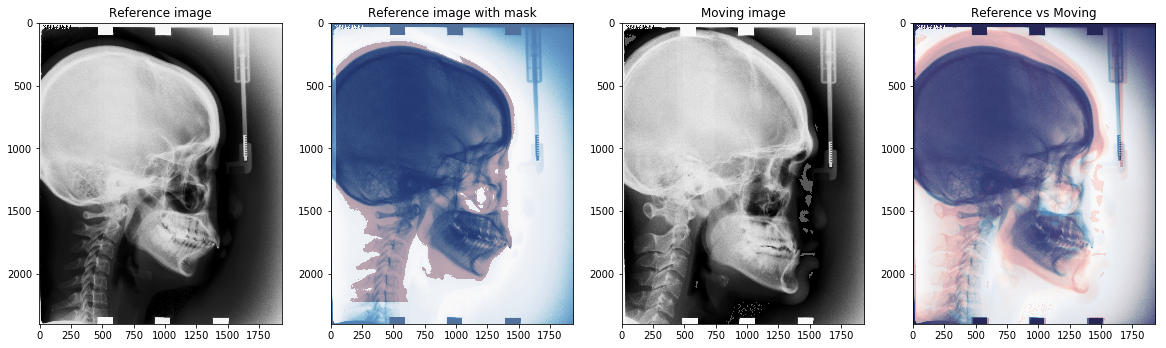

In [2]:
# load data
fix_img = sitk.ReadImage('./L3.3_utilities/001.png')
mov_img = sitk.ReadImage('./L3.3_utilities/002.png')

# load mask of reference image
fix_mask = sitk.ReadImage('./L3.3_utilities/mask001.png')
stat = sitk.StatisticsImageFilter()
stat.Execute(fix_mask)
label = stat.GetMaximum()
fix_mask = (fix_mask == label)

# TODO: get a ndarray from the images
fix_img_data = sitk.GetArrayFromImage(fix_img)
fix_mask_data = sitk.GetArrayFromImage(fix_mask)
mov_img_data = sitk.GetArrayFromImage(mov_img)

# TODO: visualization
plt.figure(figsize=(20,50))
plt.subplot(141)
plt.imshow(fix_img_data, cmap='gray') # fixed image
plt.title('Reference image')
plt.subplot(142)
plt.imshow(fix_img_data, cmap='Blues') # fixed image
plt.imshow(fix_mask_data, cmap='Reds', alpha=0.3) # mask
plt.title('Reference image with mask')
plt.subplot(143)
plt.imshow(mov_img_data, cmap='gray') # moving image
plt.title('Moving image')
plt.subplot(144)
plt.imshow(fix_img_data, cmap='Blues') # fixed image
plt.imshow(mov_img_data, cmap='Reds', alpha=0.3) # moving image
plt.title('Reference vs Moving')
plt.show()

You can now perform a simple affine registration using SimpleITK. For now, you can just work on aligning 002 to 001 without using the mask. <br>
When the registration algorithm stops running, check the result that is printed as output. __Which kind of transformations did the algorithm perform?__

In [23]:
# TODO: initial alignment of the two volumes
initial_transform = sitk.CenteredTransformInitializer(fix_img, mov_img, sitk.Similarity2DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

# initialize the registration
registration_method = sitk.ImageRegistrationMethod()

# TODO: similarity metric settings - choose an appropriate metric to be tested
# (for ex. SetMetricAsMeanSquares(), SetMetricAsMattesMutualInformation(numberOfHistogramBins=nbins), etc.)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)    
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# TODO: gradient descent optimizer
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=30, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# TODO: set the initial transformation (from the initial alignment performed above)
registration_method.SetInitialTransform(initial_transform)

# perform registration
final_transform = registration_method.Execute(sitk.Cast(fix_img, sitk.sitkFloat32), 
                                              sitk.Cast(mov_img, sitk.sitkFloat32))

print(final_transform)
print("--------")
print("Optimizer stop condition: {0}".format(registration_method.GetOptimizerStopConditionDescription()))
print("Number of iterations: {0}".format(registration_method.GetOptimizerIteration()))
print("--------")

itk::simple::Transform
 Similarity2DTransform (00000241046F5D90)
   RTTI typeinfo:   class itk::Similarity2DTransform<double>
   Reference Count: 3
   Modified Time: 561752
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00062 0.000213081 
     -0.000213081 1.00062 
   Offset: [-0.928984, -1.32535]
   Center: [967, 1199.5]
   Translation: [-0.0727353, -0.786319]
   Inverse: 
     0.999379 -0.000212816 
     0.000212816 0.999379 
   Singular: 0
   Angle       = -0.000212949
   Scale =1.00062

--------
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Number of iterations: 9
--------


You can now visually check your result by plotting the registered moving image and overlay it to the reference, in order to see whether there are some visible changes with respect to the original moving image. To do so, you will first have to resample your original moving image by using the result ('final_transform') of your registration algorithm.<br>
__What can you notice by looking at the registered image? Since you haven't used a mask, which parts of the image did the algorithm manage to align the most?__

Text(0.5,1,'Resampled moving image')

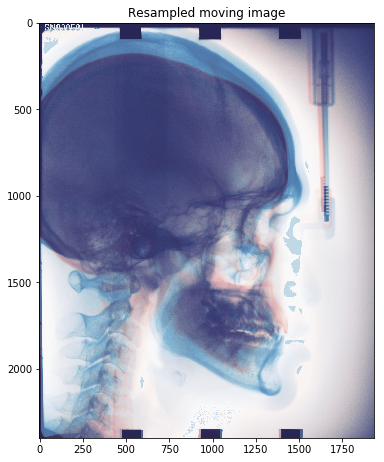

In [24]:
## resample moving image

resampler = sitk.ResampleImageFilter()

# TODO: set the reference image
resampler.SetReferenceImage(fix_img)
    
# TODO: use a linear interpolator
resampler.SetInterpolator(sitk.sitkLinear)
        
# TODO: set the desired transformation
resampler.SetTransform(final_transform)
            
mov_img_resampled = resampler.Execute(mov_img)
mov_img_resampled_data1 = sitk.GetArrayFromImage(mov_img_resampled)

# TODO: visualization of the resampled image overlaid to the fixed image
plt.figure(figsize=(6,15))
plt.imshow(mov_img_resampled_data1,cmap='Blues')
plt.imshow(fix_img_data,cmap='Reds',alpha=0.3)
plt.title('Resampled moving image')

You can now re-run your registration, but this time by using the mask001 to specify your region of interest to be aligned. __Is the resulting transformation different compared to the previous registration?__

In [25]:
# TODO: initial alignment of the two volumes
initial_transform = sitk.CenteredTransformInitializer(fix_img, mov_img, sitk.Similarity2DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

# initialize the registration
registration_method = sitk.ImageRegistrationMethod()

# TODO: similarity metric settings - choose an appropriate metric to be tested
# (for ex. SetMetricAsMeanSquares(), SetMetricAsMattesMutualInformation(numberOfHistogramBins=nbins), etc.)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50) 
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
    
# TODO: set the mask on which you are going to evaluate the similarity between the two images
registration_method.SetMetricFixedMask(fix_mask)
    
# interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# TODO: gradient descent optimizer
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=30, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# TODO: set the initial transformation (from the initial alignment performed above)
registration_method.SetInitialTransform(initial_transform)

# perform registration
final_transform = registration_method.Execute(sitk.Cast(fix_img, sitk.sitkFloat32), 
                                              sitk.Cast(mov_img, sitk.sitkFloat32))

print(final_transform)
print("--------")
print("Optimizer stop condition: {0}".format(registration_method.GetOptimizerStopConditionDescription()))
print("Number of iterations: {0}".format(registration_method.GetOptimizerIteration()))
print("--------")

itk::simple::Transform
 Similarity2DTransform (00000241046F5C40)
   RTTI typeinfo:   class itk::Similarity2DTransform<double>
   Reference Count: 3
   Modified Time: 662978
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00456 -0.0067221 
     0.0067221 1.00456 
   Offset: [-12.1334, 4.47306]
   Center: [967, 1199.5]
   Translation: [-15.7849, 16.4457]
   Inverse: 
     0.995414 0.00666088 
     -0.00666088 0.995414 
   Singular: 0
   Angle       = 0.00669147
   Scale =1.00458

--------
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (30) exceeded.
Number of iterations: 30
--------


You can now visually check your result. __Which are the main differences compared to the previous registration?__

Text(0.5,1,'Resampled moving image')

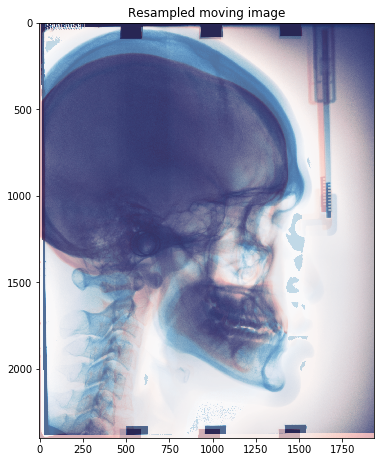

In [26]:
# TODO: resample moving image

resampler = sitk.ResampleImageFilter()

# TODO: set the reference image
resampler.SetReferenceImage(fix_img)
    
# TODO: use a linear interpolator
resampler.SetInterpolator(sitk.sitkLinear)
        
# TODO: set the desired transformation
resampler.SetTransform(final_transform)
            
mov_img_resampled = resampler.Execute(mov_img)
mov_img_resampled_data2 = sitk.GetArrayFromImage(mov_img_resampled)

# TODO: visualization of the resampled image overlaid to the fixed image
plt.figure(figsize=(6,15))
plt.imshow(mov_img_resampled_data2,cmap='Blues')
plt.imshow(fix_img_data,cmap='Reds',alpha=0.3)
plt.title('Resampled moving image')

Text(0.5,1,'Overlapping results')

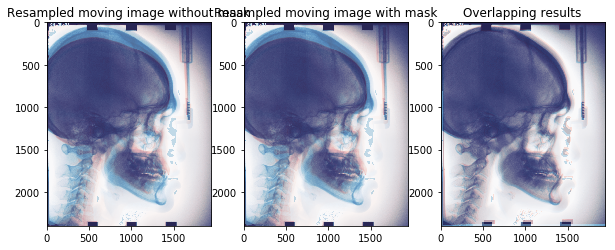

In [28]:
plt.figure(figsize=(10,20))
plt.subplot(131)
plt.imshow(mov_img_resampled_data1,cmap='Blues')
plt.imshow(fix_img_data,cmap='Reds',alpha=0.3)
plt.title('Resampled moving image without mask')

plt.subplot(132)
plt.imshow(mov_img_resampled_data1,cmap='Blues')
plt.imshow(fix_img_data,cmap='Reds',alpha=0.3)
plt.title('Resampled moving image with mask')

plt.subplot(133)
plt.imshow(mov_img_resampled_data1,cmap='Blues')
plt.imshow(mov_img_resampled_data2,cmap='Reds',alpha=0.3)
plt.title('Overlapping results')

## OPTIONAL - Landmark-based registration

Start by importing the following modules:

In [29]:
# from Insight Software Consortium Github
import sys
sys.path.append('./L3.3_utilities')
import registration_utilities as ru

### Load and visualize data
You can now read and visualize the data you are going to work with. They are the training data of one subject from the Retrospective Image Registration Evaluation [(RIRE)](http://www.insight-journal.org/rire/) project. They consist of a CT and MR scan of the patient with a known rigid transformation between the two.<br>
Below, you can read the data (as well as the known transformation) and visualize them.

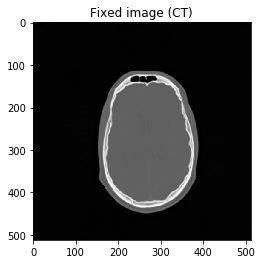

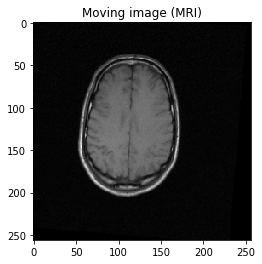

In [30]:
# load data
fix_img = sitk.ReadImage('./L3.3_utilities/ct/training_001_ct.mhd', sitk.sitkFloat32)
mov_img = sitk.ReadImage('./L3.3_utilities/mr_T1/training_001_mr_T1.mhd', sitk.sitkFloat32)
fix_fiducial_points, mov_fiducial_points = ru.load_RIRE_ground_truth('./L3.3_utilities/transformations/ct_T1.standard')

# visualization of one slice of fix_img
# TODO: get a numpy data array from the image
fix_img_data =sitk.GetArrayFromImage(fix_img)
# TODO: get image dimensions
imageSize = fix_img.GetSize()
n_slices = imageSize[2]
# plot
plt.figure()
plt.imshow(fix_img_data[int(n_slices/2),:,::-1], cmap='gray')
plt.title('Fixed image (CT)')
plt.show()

# visualization of one slice of mov_img
# TODO: get a numpy data array from the image
mov_img_data = sitk.GetArrayFromImage(mov_img)
# TODO: get image dimensions
imageSize = mov_img.GetSize()
n_slices = imageSize[2]
# plot
plt.figure()
plt.imshow(mov_img_data[int(n_slices/2),:,::-1], cmap='gray')
plt.title('Moving image (MRI)')
plt.show()

You can now used the known rigid transformation in order to define two corresponding point sets in the two images. In this way, it is possible to compute the target registration error (TRE), which is a metric of the degree of dissimilarity between the two images.

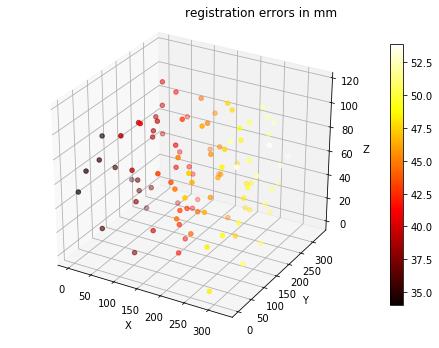

Before registration, errors (TRE) in millimeters, mean(std): 44.50(5.34), max: 53.91


In [31]:
# flatten the tuples representing the fiducial points
fix_fiducial_points_flat = [c for p in fix_fiducial_points for c in p]
mov_fiducial_points_flat = [c for p in mov_fiducial_points for c in p]
ref_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(),
                                                             fix_fiducial_points_flat,
                                                             mov_fiducial_points_flat)

# generate a reference dataset in both images (corresponding to specific points in both the fixed and moving image)
fix_points = ru.generate_random_pointset(image=fix_img, num_points=100)
mov_points = [ref_transform.TransformPoint(p) for p in fix_points]

# compute the target registration error (TRE) before performing the registration
pre_errors_mean, pre_errors_std, pre_errors_min, pre_errors_max, pre_errors = ru.registration_errors(sitk.Euler3DTransform(), fix_points, mov_points, display_errors=True) 
print('Before registration, errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(pre_errors_mean, pre_errors_std, pre_errors_max))


### Manual landmark localization
You are now ready to perform a manual landmark localization. Run the function below and select three corresponding landmarks in the two images (three landmarks per image). From the GUI, you will see that there are two possible modes:
- 'edit', in which you have to select your landmarks. For each landmark, you should first select it in one of the two (e.g. the fixed image) and then select the same landmark in the other image (the moving image) in order to have a correspondence between the two.
- 'view', in which the landmark selection is disabled and you are free to zoom/pan the image if you want to be more precise in the landmark localization.

<IPython.core.display.Javascript object>


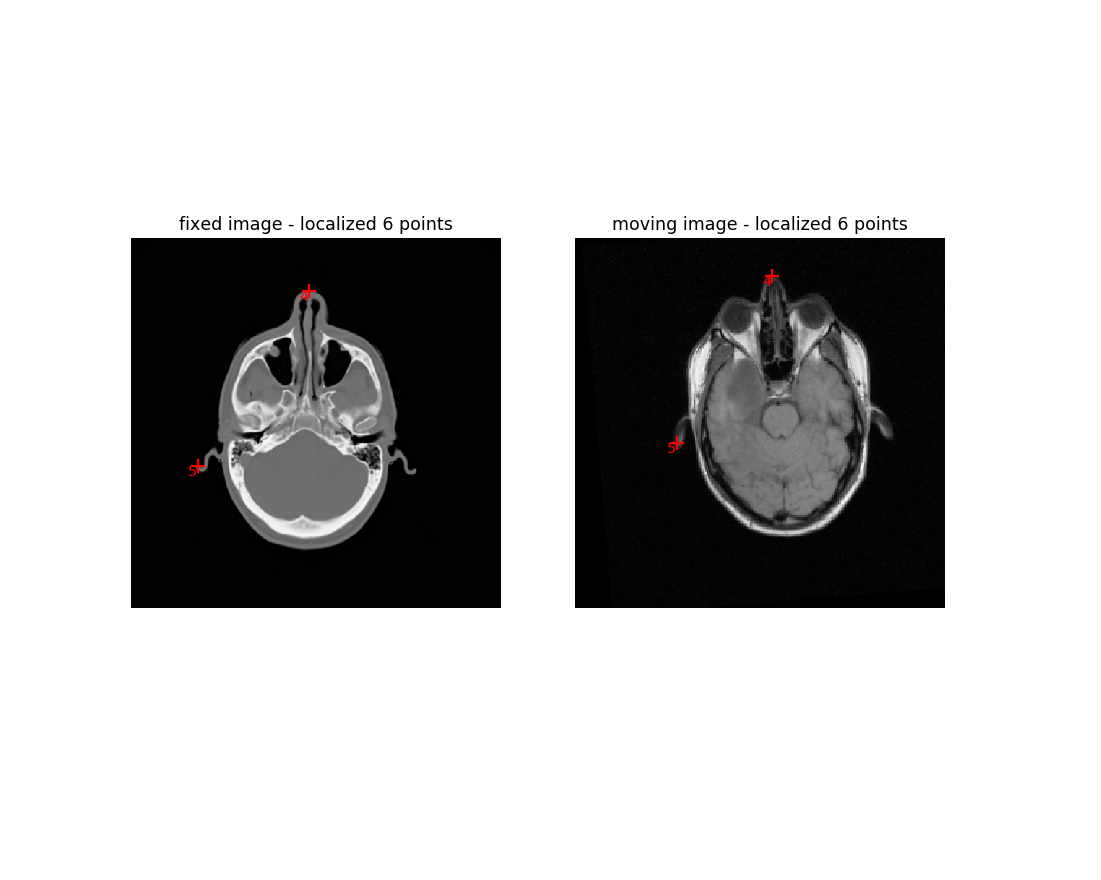

HBox(children=(HBox(children=(Box(children=(RadioButtons(description='Interaction mode:', options=('edit', 'view'), value='edit'),)), Box(children=(Button(description='Clear Last', style=ButtonStyle()),)), Box(children=(Button(description='Clear All', style=ButtonStyle()),)))), Box(children=(IntSlider(value=14, description='fixed image z slice:', max=28), IntSlider(value=12, description='moving image z slice:', max=25)))))

In [32]:
%matplotlib notebook
import gui

point_acquisition_interface = gui.RegistrationPointDataAquisition(fix_img, mov_img)

Once you are ready, you can store the acquired landmarks in the two variables: 'fix_img_points' and 'mov_img_points'.

In [33]:
fix_img_points, mov_img_points = point_acquisition_interface.get_points()
print(fix_img_points)
print(mov_img_points)

[(157.94398400079052, 95.82566957719811, 56.0), (120.89602835562924, 261.1165486094562, 56.0), (213.04094367820986, 154.72241957719808, 56.0), (213.04094367820986, 153.77246939197366, 56.0), (160.793826742726, 47.37834035971566, 0.0), (60.09938319433891, 206.01958632745757, 0.0)]
[(172.77042086693555, 59.5272201818446, 48.0), (148.24396925403235, 229.39560727861877, 48.0), (230.907195060484, 124.02270405281229, 48.0), (231.81558215725815, 122.2059273686358, 48.0), (170.045259576613, 32.27560478799063, 0.0), (87.38203377016141, 176.70915317508744, 0.0)]


Finally, you can use the selected points in order to perform landmark-based segmentation with SimpleITK.<br>
Analyze the registration error in mm, similarly to what you did above with the non-transformed images. __Did you manage to get an improvement in the alignment by using your landmarks?__

<IPython.core.display.Javascript object>


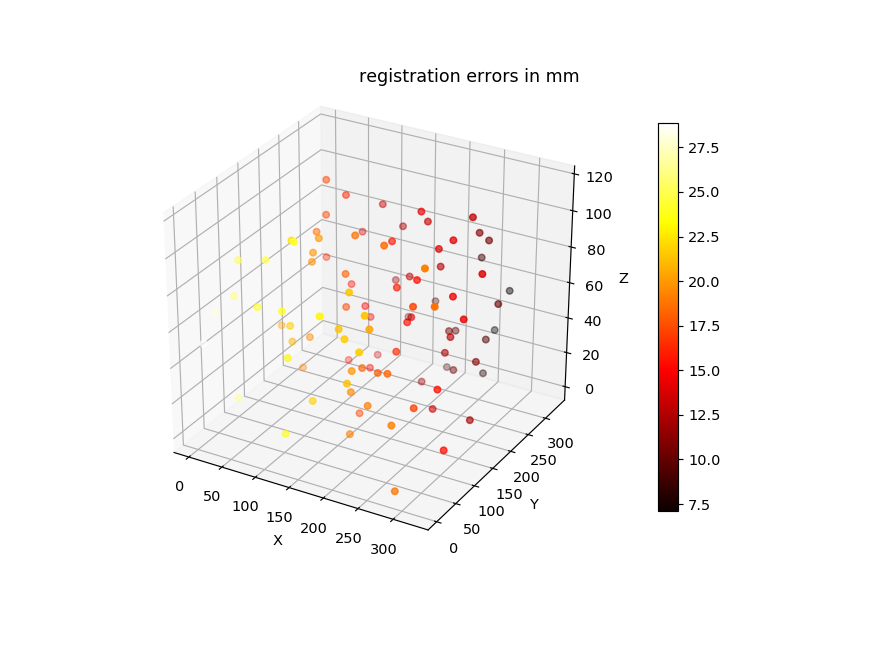

After registration (manual point localization), errors (TRE) in millimeters, mean(std): 16.82(4.88), max: 28.86


In [34]:
fix_img_points_flat = [c for p in fix_img_points for c in p]        
mov_img_points_flat = [c for p in mov_img_points for c in p]

# rigid transformation based on landmarks
manual_localized_transformation = sitk.VersorRigid3DTransform(sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                         fix_img_points_flat, 
                                                                         mov_img_points_flat))

# compute the TRE after having performed the registration
manual_errors_mean, manual_errors_std, manual_errors_min, manual_errors_max,_ = \
    ru.registration_errors(manual_localized_transformation,
                           fix_points, 
                           mov_points, 
                           display_errors=True)
print('After registration (manual point localization), errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(manual_errors_mean, manual_errors_std, manual_errors_max))

By using the function below, you can also visually evaluate the performance of the registration by localizing corresponding points and verifying if they actually match!

<IPython.core.display.Javascript object>


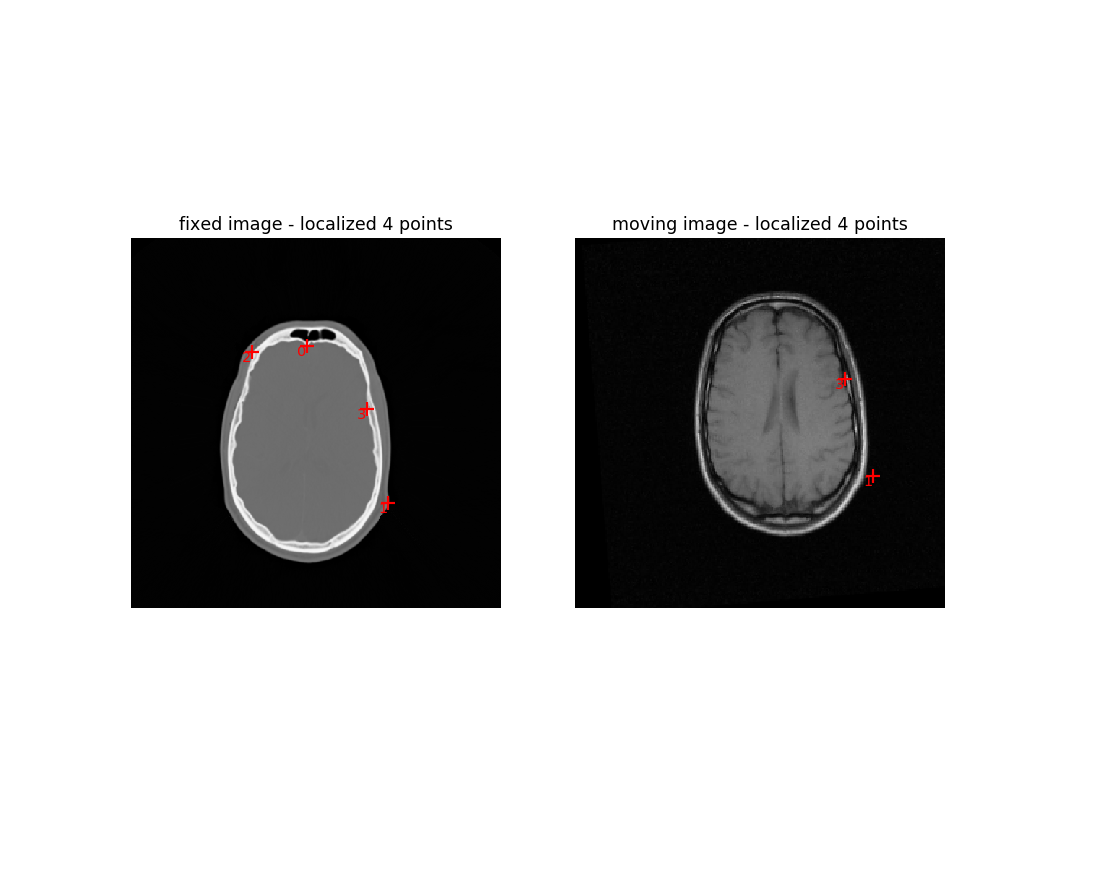

HBox(children=(HBox(children=(Box(children=(RadioButtons(description='Interaction mode:', options=('edit', 'view'), value='edit'),)), Box(children=(Button(description='Clear Last', style=ButtonStyle()),)), Box(children=(Button(description='Clear All', style=ButtonStyle()),)))), Box(children=(IntSlider(value=14, description='fixed image z slice:', max=28), IntSlider(value=12, description='moving image z slice:', max=25)))))

In [35]:
gui.RegistrationPointDataAquisition(fix_img, mov_img, known_transformation=manual_localized_transformation)

### Semiautomatic landmark localization

You will now try to improve the localization of the fixed landmarks in the moving image (and therefore the final performance of the landmark-based registration) by first performing a rigid registration between the two images.<br>
You can start by performing the registration and getting the transformation 'final_trasform'.

In [36]:
# TODO: initial alignment of the volumes
initial_transform = sitk.CenteredTransformInitializer(fix_img, mov_img, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

# initialize the registration
registration_method = sitk.ImageRegistrationMethod()

# TODO: similarity metric settings - which metric is the most appropriate with the given type of data?
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# TODO: linear interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# optimizer
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# setup for the multi-resolution framework
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# TODO: set initial transformation
registration_method.SetInitialTransform(initial_transform)

# perform registration
final_transform = registration_method.Execute(sitk.Cast(fix_img, sitk.sitkFloat32), 
                                              sitk.Cast(mov_img, sitk.sitkFloat32))

You can re-use the function that you have seen before (_RegistrationPointDataAcquisition_) in order to check whether the registration worked.

Choose 3 landmarks

<IPython.core.display.Javascript object>


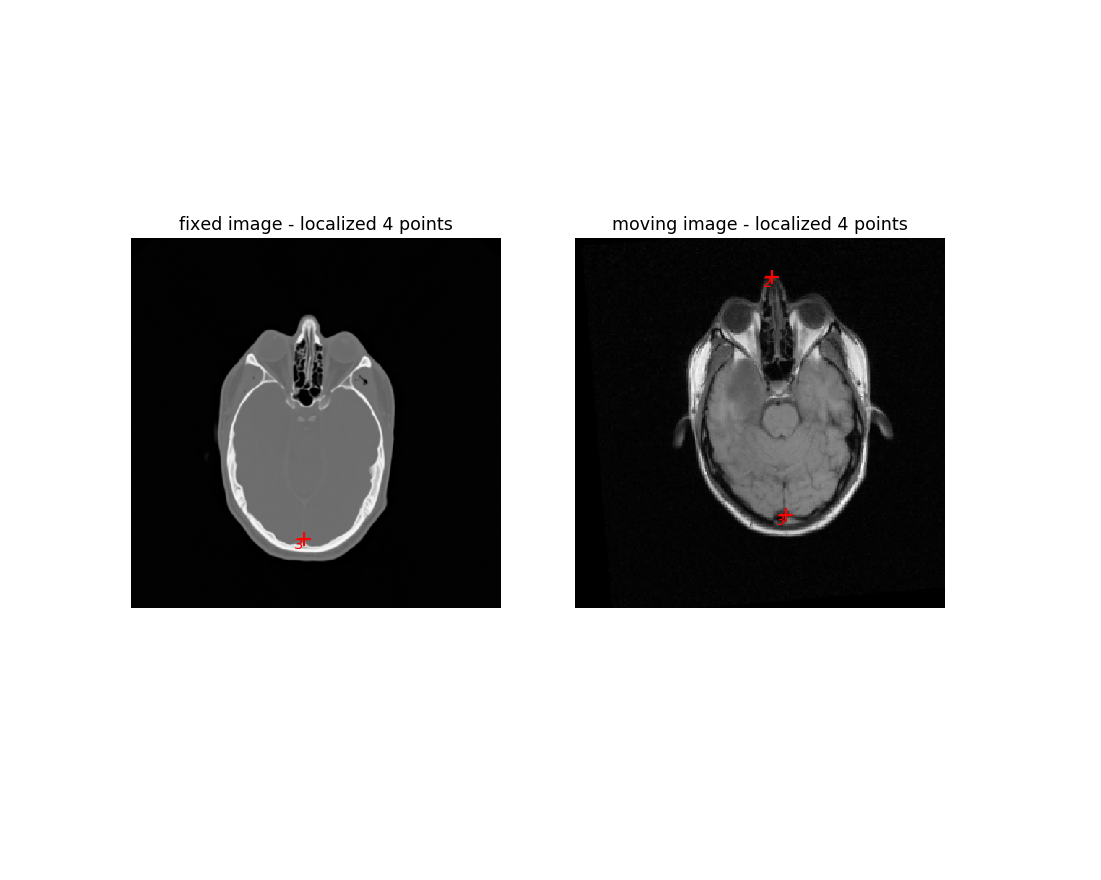

HBox(children=(HBox(children=(Box(children=(RadioButtons(description='Interaction mode:', options=('edit', 'view'), value='edit'),)), Box(children=(Button(description='Clear Last', style=ButtonStyle()),)), Box(children=(Button(description='Clear All', style=ButtonStyle()),)))), Box(children=(IntSlider(value=14, description='fixed image z slice:', max=28), IntSlider(value=12, description='moving image z slice:', max=25)))))

In [37]:
# TODO: visualize the result
gui.RegistrationPointDataAquisition(fix_img, mov_img, known_transformation=final_transform)

You can now use the derived 'final_transform' in order to find the updated landmarks in the moving image (corresponding to those that you have previously selected manually in the fixed image).

In [42]:
# update the position of the moving image points
updated_mov_img_points = [final_transform.TransformPoint(p) for p in fix_img_points]

Analyze again the registration error in mm. __Did you manage to get a further improvement in the alignment by using the semi-automatic method?__

<IPython.core.display.Javascript object>


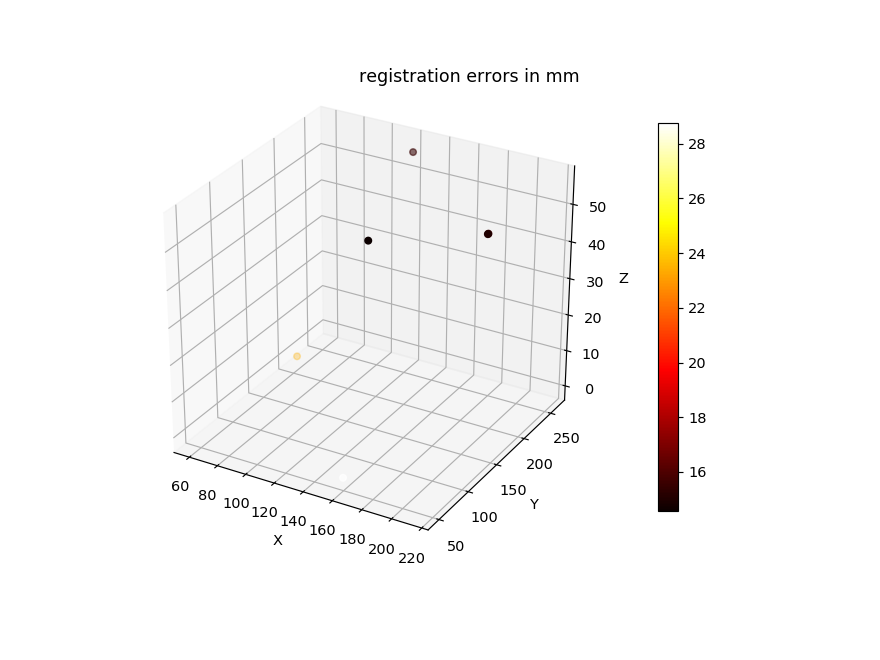

After registration (semiautomatic point localization), errors (TRE) in millimeters, mean(std): 18.79(5.41), max: 28.76


In [43]:
# landmark registration
updated_mov_img_points_flat = [c for p in updated_mov_img_points for c in p]        
semi_automatic_transform = sitk.VersorRigid3DTransform(sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                         fix_img_points_flat, 
                                                                         updated_mov_img_points_flat))

# TODO: compute the TRE after having performed the registration
semi_automatic_errors_mean, semi_automatic_errors_std, semi_automatic_errors_min, semi_automatic_errors_max,_ = \
    ru.registration_errors(semi_automatic_transform,
                           fix_img_points, 
                           mov_img_points, 
                           display_errors=True)
    
print('After registration (semiautomatic point localization), errors (TRE) in millimeters, mean(std): {:.2f}({:.2f}), max: {:.2f}'.format(semi_automatic_errors_mean, 
                                                                                                                                          semi_automatic_errors_std,
                                                                                                                               semi_automatic_errors_max))

You can try to re-run your landmark-based registration by changing the landmarks and/or adding more landmarks. __Which choices led you to a better performance?__